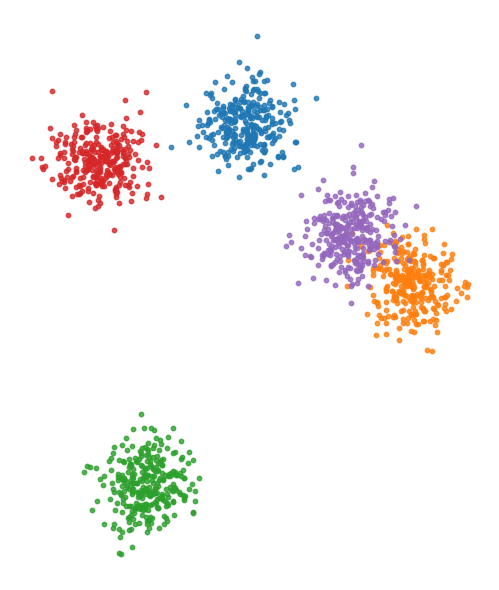

In [1]:
"""
File by Bryan

Synthesizes cluster evaluation data for structural clusters and creates plots
"""


import numpy as np
import matplotlib.pyplot as plt

save_dir = (
    '/home/ms3955/qcb551_proj/structural_figures'
    #'/Users/bc/pu/cg/final_project'
)

# Parameters
n_clusters = 5
points_per_cluster = 300
cluster_spread = 0.5
random_seed = 42

np.random.seed(random_seed)

# Generate fake cluster centers
centers = np.random.uniform(-5, 5, size=(n_clusters, 2))

# Generate points around each center
X = []
y = []
for i, c in enumerate(centers):
    pts = np.random.normal(loc=c, scale=cluster_spread, size=(points_per_cluster, 2))
    X.append(pts)
    y.extend([i] * points_per_cluster)

X = np.vstack(X)
y = np.array(y)

# Plot
plt.figure(figsize=(6, 6))
for i in range(n_clusters):
    cluster_points = X[y == i]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=10,
        alpha=0.8,
        label=f"Cluster {i+1}"
    )

plt.axis("off")
plt.gca().set_aspect("equal")
plt.tight_layout()
#plt.savefig(f"{save_dir}/fake_umap.svg", bbox_inches="tight")
plt.show()

In [2]:
with open("./1k_proteins.out", "r") as f:
    lines = f.read().splitlines()

In [3]:
spacing = 292
embeddings = [lines[0], lines[spacing * 1], lines[spacing * 2],lines[spacing * 3], lines[spacing * 4]]
embeddings = ['bag_of_words',
 'esm2_8M',
 'esm2_35M',
 'esm2_150M',
 'prot_bert']
similarities = ['cosine', 'euclidean', 'geodesic']
clustering_methods = ['hierarchical', 'kmeans', 'spectral']

In [5]:
import pandas as pd

ari     = [float(line.split("= ")[-1]) for line in lines if line.startswith("ARI")]
nmi     = [float(line.split("= ")[-1]) for line in lines if line.startswith("NMI")]
jac = (
    #"Jaccard macro (true → best cluster)"
    #"Jaccard macro (cluster → best true)"
    "Jaccard macro (Hungarian-aligned pairs)"
)
jaccard = [float(line.split("= ")[-1]) for line in lines if line.startswith(jac)]
mapping = [float(line.split("= ")[-1]) for line in lines if line.startswith("Mapping")]

M = np.vstack([ari, nmi, jaccard, mapping])

In [6]:
M[M < 0]

array([], dtype=float64)

In [7]:
import itertools
records = []
metrics = ["ARI", "NMI", "Jaccard", "Mapping"]

for (emb, sim, clust), col_idx in zip(itertools.product(embeddings, similarities, clustering_methods), range(M.shape[1])):
    for row_idx, metric in enumerate(metrics):
        records.append({
            "metric": metric,
            "embedding": emb,
            "similarity": sim,
            "clustering": clust,
            "value": M[row_idx, col_idx]
        })

long_df = pd.DataFrame(records)

In [8]:
long_df

,metric,embedding,similarity,clustering,value
0,ARI,bag_of_words,cosine,hierarchical,0.0683
1,NMI,bag_of_words,cosine,hierarchical,0.2278
2,Jaccard,bag_of_words,cosine,hierarchical,0.1284
3,Mapping,bag_of_words,cosine,hierarchical,0.2679
4,ARI,bag_of_words,cosine,kmeans,0.1584
...,...,...,...,...,...
175,Mapping,prot_bert,geodesic,kmeans,0.2943
176,ARI,prot_bert,geodesic,spectral,0.1200
177,NMI,prot_bert,geodesic,spectral,0.1983
178,Jaccard,prot_bert,geodesic,spectral,0.2390


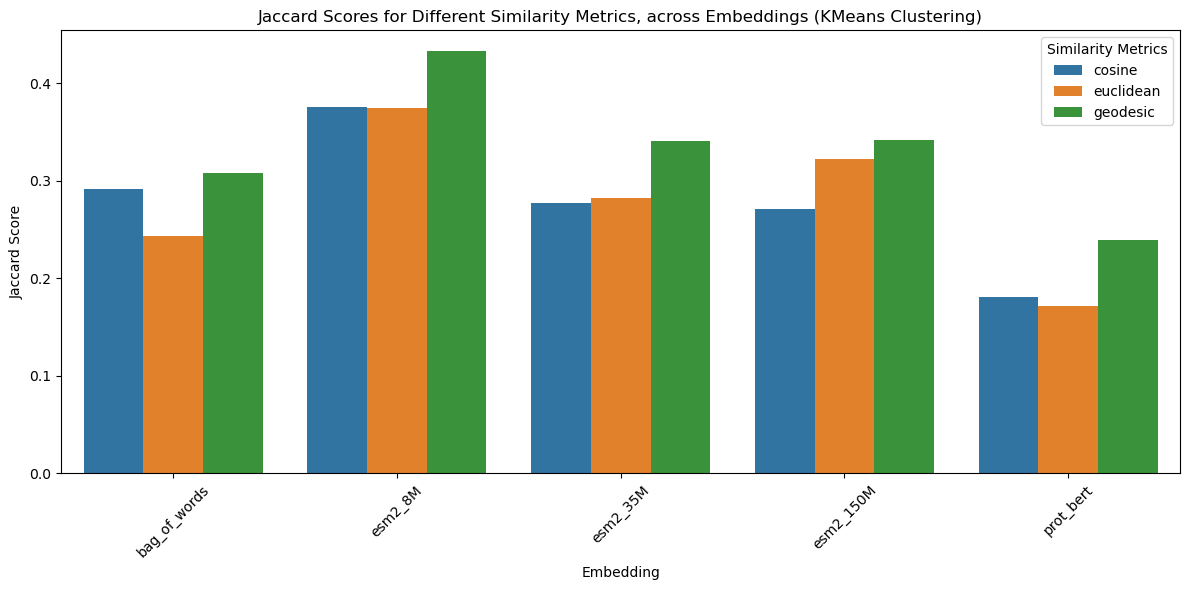

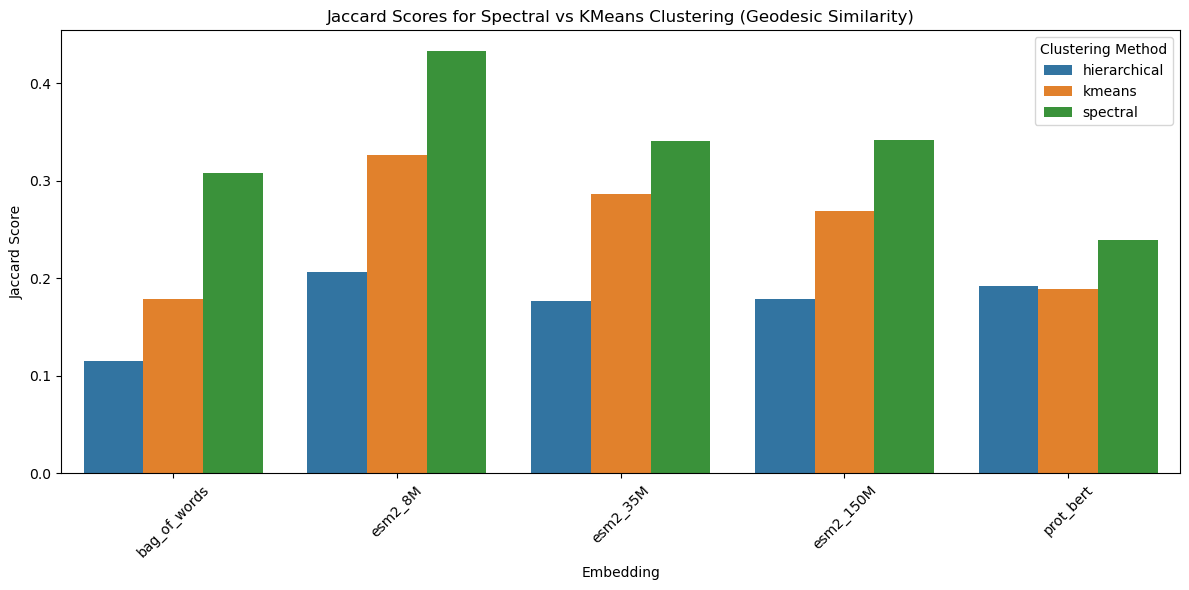

In [13]:
# Plot a bar plot showing Jaccard scores for each embedding compared across similarity metrics for KMeans clustering.
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df[(long_df['metric'] == 'Jaccard') & (long_df['clustering'] == 'spectral')], 
            x='embedding', y='value', hue='similarity', errorbar=None)
plt.title('Jaccard Scores for Different Similarity Metrics, across Embeddings (KMeans Clustering)')
plt.xlabel('Embedding')
plt.ylabel('Jaccard Score')
plt.legend(title='Similarity Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{save_dir}/similarity_metrics.png", bbox_inches="tight", dpi=300)
plt.show()

# Plot a bar plot showing Jaccard scores for each embedding comparing Spectral vs KMeans clustering for Geodesic similarity.
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df[(long_df['metric'] == 'Jaccard') & (long_df['similarity'] == 'geodesic')], 
            x='embedding', y='value', hue='clustering', errorbar=None)
plt.title('Jaccard Scores for Spectral vs KMeans Clustering (Geodesic Similarity)')
plt.xlabel('Embedding')
plt.ylabel('Jaccard Score')
plt.legend(title='Clustering Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{save_dir}/clustering_comparison.png", bbox_inches="tight", dpi=300)
plt.show()

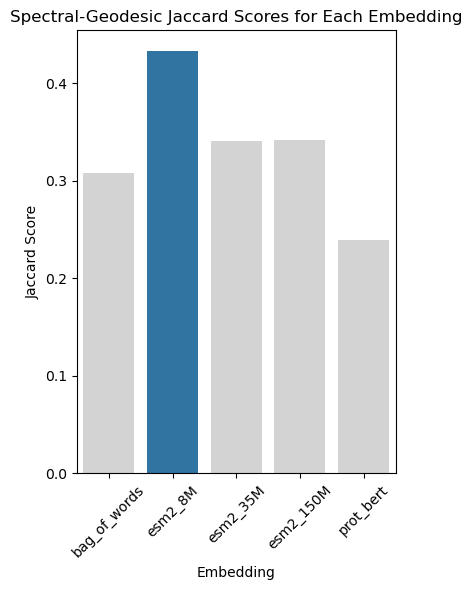

In [16]:
df_plot = long_df[
    (long_df['metric'] == 'Jaccard') &
    (long_df['similarity'] == 'geodesic') &
    (long_df['clustering'] == 'spectral')
]

# color mapping: highlight esm2_8M, grey for the rest
palette = {
    emb: ("tab:blue" if emb == "esm2_8M" else "lightgray")
    for emb in df_plot["embedding"].unique()
}

plt.figure(figsize=(4, 6))
ax = sns.barplot(
    data=df_plot,
    x="embedding",
    y="value",
    hue="embedding",
    palette=palette,
    dodge=False,
    errorbar=None
)

# remove the hue legend so the plot looks like a plain barplot
if ax.get_legend() is not None:
    ax.legend_.remove()

ax.set_title("Spectral-Geodesic Jaccard Scores for Each Embedding")
ax.set_xlabel("Embedding")
ax.set_ylabel("Jaccard Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{save_dir}/best_combo_jaccard.svg", bbox_inches="tight")
plt.show()

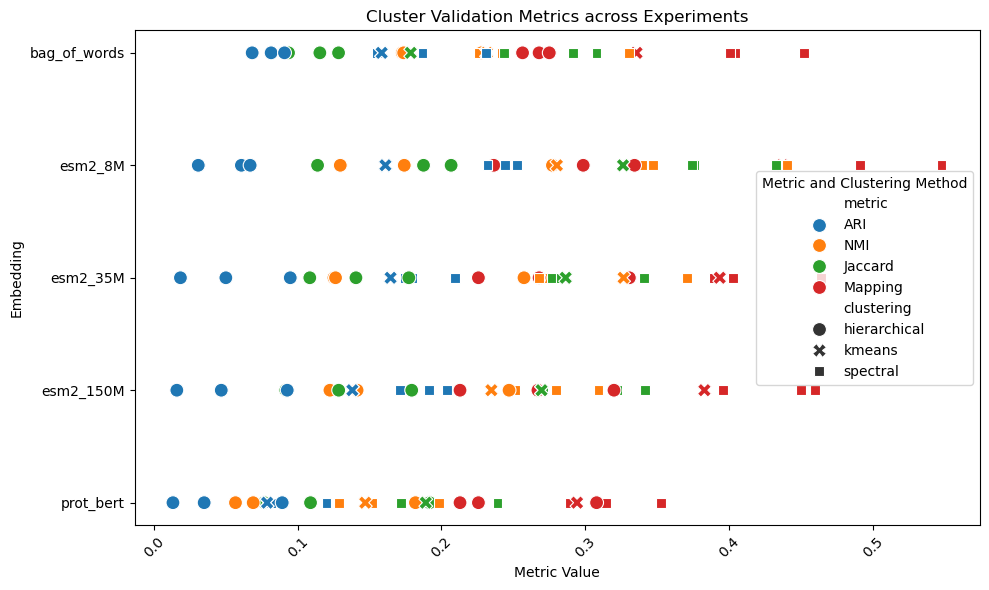

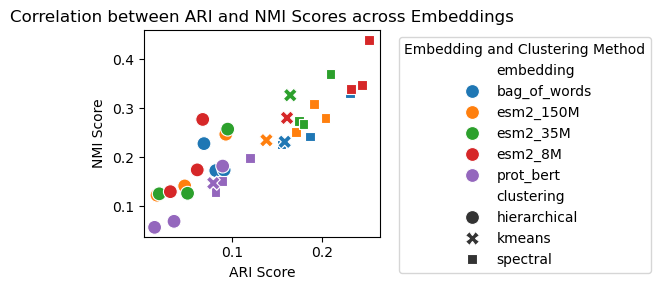

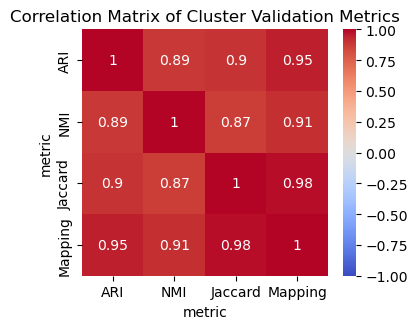

In [17]:
# Each entry in long_df can have a 4-long vector of values for ARI, NMI, Jaccard, and Mapping. We can plot these as a scatter plot to see how they correlate.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=long_df, x='value', y='embedding', hue='metric', style='clustering', s=100)
plt.title('Cluster Validation Metrics across Experiments')
plt.xlabel('Metric Value')
plt.ylabel('Embedding')
plt.legend(title='Metric and Clustering Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{save_dir}/metrics_scatter.svg", bbox_inches="tight")
plt.show()

# I  make a scatter plot where one axis is the ARI score, and the other axis is the NMI score, and each point is colored by the embedding type. This way I can see if there's a correlation between ARI and NMI scores across different embeddings.
# I can do this by pivoting the long_df to have ARI and NMI as separate columns for this plot.
pivot_df = long_df.pivot_table(index=['embedding', 'similarity', 'clustering'], columns='metric', values='value').reset_index()
plt.figure(figsize=(6, 3))
sns.scatterplot(data=pivot_df, x='ARI', y='NMI', hue='embedding', style='clustering', s=100)
plt.title('Correlation between ARI and NMI Scores across Embeddings')
plt.xlabel('ARI Score')
plt.ylabel('NMI Score')
plt.legend(title='Embedding and Clustering Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{save_dir}/ari_nmi_correlation.svg", bbox_inches="tight")
plt.show()

# Now calculate the correlation between all pairs of metrics (ARI vs NMI, ARI vs Jaccard, ARI vs Mapping, NMI vs Jaccard, NMI vs Mapping, Jaccard vs Mapping).
metrics = ['ARI', 'NMI', 'Jaccard', 'Mapping']
for i in range(len(metrics)):
    for j in range(i + 1, len(metrics)):
        metric_x = metrics[i]
        metric_y = metrics[j]
        correlation = pivot_df[metric_x].corr(pivot_df[metric_y])

# Plot the correlation between pairs of metrics as a heatmap.
corr_matrix = pivot_df[metrics].corr()
plt.figure(figsize=(4, 3.4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Cluster Validation Metrics')
plt.tight_layout()
plt.savefig(f"{save_dir}/correlation_matrix.svg", bbox_inches="tight")
plt.show()